In [1]:
import numpy as np

from qiskit import *
from qiskit.tools.monitor import job_monitor

from qiskit import assemble,pulse,QuantumCircuit,schedule,transpile
from qiskit.pulse.channels import ControlChannel, DriveChannel

from qiskit.circuit import Gate
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.test.mock import FakeValencia,FakeBogota, FakeArmonk
from qiskit.visualization import plot_histogram

from qiskit.visualization.pulse_v2 import draw, IQXSimple, IQXDebugging,IQXStandard

In [ ]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver)

from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper

import numpy as np

In [12]:
from scipy.optimize import minimize
from matplotlib.pyplot import figure
from scipy.interpolate import UnivariateSpline

In [ ]:
Atomic_distance_array = np.append(np.arange(0.3, 1, 0.05), (np.arange(1, 1.599, 0.1)))

Coeffs_Pauli_Op_distance = []

for i in range(len(Atomic_distance_array)):
    
    molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, Atomic_distance_array[i]]]], charge=0, multiplicity=1)
    driver = ElectronicStructureMoleculeDriver(molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)
    
    es_problem = ElectronicStructureProblem(driver)
    second_q_op = es_problem.second_q_ops()
    
    qubit_converter = QubitConverter(mapper=JordanWignerMapper(), z2symmetry_reduction=[-1,1,-1])
    qubit_op = qubit_converter.convert(second_q_op[0])
    
    coeffs = []
    
    for j in range(3):
        coeffs.append(qubit_op[j].coeffs[0])
    
    Coeffs_Pauli_Op_distance.append(coeffs)

Real_Coeffs_Pauli_Op_distance = np.real(Coeffs_Pauli_Op_distance)  

In [141]:
len(Real_Coeffs_Pauli_Op_distance)
Real_Coeffs_Pauli_Op_distance

array([[-0.74045398, -1.61729782,  0.16081852],
       [-0.79755815, -1.49483165,  0.16257322],
       [-0.84966556, -1.37763886,  0.16451542],
       [-0.89568293, -1.26777957,  0.1666214 ],
       [-0.93519145, -1.16615925,  0.16887023],
       [-0.96821355, -1.07297757,  0.17124452],
       [-0.99506269, -0.98802757,  0.17373064],
       [-1.01624849, -0.91086684,  0.17631845],
       [-1.03240512, -0.84091136,  0.17900058],
       [-1.04422589, -0.77749518,  0.18177154],
       [-1.05240306, -0.71991885,  0.18462678],
       [-1.05757899, -0.66749299,  0.18756185],
       [-1.06031416, -0.61957456,  0.19057169],
       [-1.06107359, -0.57559198,  0.19365032],
       [-1.06022856, -0.5350573 ,  0.19679058],
       [-1.05481731, -0.46279175,  0.20322223],
       [-1.04570856, -0.40037915,  0.20979147],
       [-1.0339543 , -0.34621571,  0.21641746],
       [-1.0203285 , -0.29913588,  0.22302209],
       [-1.00545574, -0.25820263,  0.22953594]])

In [77]:
#define pulsesimulator from the backend profile
#backend = FakeBogota()
#backend = FakeValencia()
backend = FakeArmonk()


# setting for build pulse simulation
model = PulseSystemModel.from_backend(backend)
qubit_lo_freq = model.hamiltonian.get_qubit_lo_from_drift()
backend_sim = PulseSimulator(system_model = model)
backend_sim.set_options(qubit_lo_freq=backend.defaults().qubit_freq_est)


In [62]:
def quantum_state_preparation(circuit, parameters):
    q = circuit.qregs[0] # q is the quantum register where the info about qubits is stored
    circuit.rx(parameters[0], q[0]) # q[0] is our one and only qubit XD
    circuit.ry(parameters[1], q[0])
    return circuit

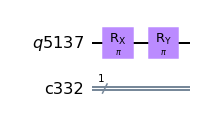

In [86]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
circuit = QuantumCircuit(q, c)
circuit.rx(np.pi, q[0]) # q[0] is our one and only qubit XD
circuit.ry(np.pi, q[0])
circuit.draw('mpl')

In [97]:
def vqe_circuit(parameters, measure):
    """
    Creates a device ansatz circuit for optimization.
    :param parameters_array: list of parameters for constructing ansatz state that should be optimized.
    :param measure: measurement type. E.g. 'Z' stands for Z measurement.
    :return: quantum circuit.
    """
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q, c)

    # quantum state preparation
    circuit = quantum_state_preparation(circuit, parameters)

    # measurement
    if measure == 'Z':
        circuit.measure(q[0], c[0])
    elif measure == 'X':
        circuit.h(q[0])
        circuit.measure(q[0], c[0])
    else:
        raise ValueError('Not valid input for measurement: input should be "Z" or "X"')

    return circuit

In [98]:
def quantum_module(parameters, measure):
    # measure
    if measure == 'I':
        return 1
    elif measure == 'Z':
        circuit = vqe_circuit(parameters, 'Z')
    elif measure == 'X':
        circuit = vqe_circuit(parameters, 'X')
    else:
        raise ValueError('Not valid input for measurement: input should be "I" or "X" or "Z" or "Y"')
    
    qc_t = transpile(circuit, backend)
    pulse_sched_qc = schedule(qc_t, backend)
    
    shots=8192
    result = backend.run(pulse_sched_qc, shots=shots).result()
    counts = result.get_counts()
    
    # expectation value estimation from counts
    expectation_value = 0
    for measure_result in counts:
        sign = +1
        if measure_result == '1':
            sign = -1
        expectation_value += sign * counts[measure_result] / shots
        
    return expectation_value

In [109]:
def vqe(parameters, Real_Coeffs_Pauli_Op):
        
    # quantum_modules
    quantum_module_I = Real_Coeffs_Pauli_Op[0] * quantum_module(parameters, 'I')
    quantum_module_Z = Real_Coeffs_Pauli_Op[1] * quantum_module(parameters, 'Z')
    quantum_module_X = Real_Coeffs_Pauli_Op[2] * quantum_module(parameters, 'X')
    
    # summing the measurement results
    classical_adder = quantum_module_I + quantum_module_Z + quantum_module_X
    
    return classical_adder

In [133]:
parameters_array = np.array([-np.pi/2, np.pi/2])
tol = 1e-2 # tolerance for optimization precision.

min_E_distance = []

for i in range(len(Real_Coeffs_Pauli_Op_distance)):
    
    vqe_result = minimize(vqe, parameters_array, Real_Coeffs_Pauli_Op_distance[i], method="Powell", tol=tol)
    #print('The exact ground state energy is: {}'.format(-1.13722138))
    #print('The estimated ground state energy from VQE algorithm is: {}'.format(vqe_result.fun))
    min_E_distance.append(vqe_result.fun)

min_E_distance

[-2.359617022069011,
 -2.3015258530341685,
 -2.237383351690151,
 -2.1702452263811356,
 -2.1147630515000597,
 -2.0549999193228357,
 -1.9989645402759324,
 -1.9434822771662026,
 -1.8887698863093043,
 -1.841835008974875,
 -1.7901398654822085,
 -1.750556506092765,
 -1.7021285521827556,
 -1.6540199563359002,
 -1.628581810364131,
 -1.5575767770476872,
 -1.5000826767735707,
 -1.4360053675226403,
 -1.38968411703306,
 -1.339265889478158]

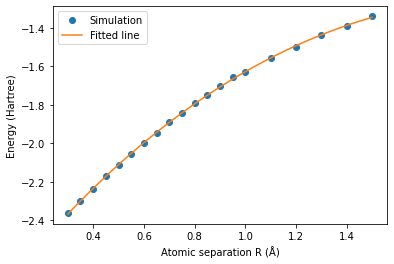

In [139]:
x = Atomic_distance_array
y = min_E_distance

f = UnivariateSpline(x, y, s=0.5)

# calculate new x's and y's
x_new = np.linspace(x[0], x[len(Atomic_distance_array)-1], 1000)
y_new = f(x_new)

plt.plot(x,y,'o', label = 'Simulation')
plt.plot(x_new, y_new, label = 'Fitted line')
#plt.xlim([x[0]-0.15, x[-1] + 0.15 ])
#plt.ylim(-1.16,-0.9)
plt.legend()
plt.xlabel('Atomic separation R (Å)')
plt.ylabel('Energy (Hartree)')
plt.show()

In [ ]:
New Hamitonian  ####

In [ ]:
simulator ####

In [155]:
Real_Coeffs_Pauli_Op_distance = [] #You need to add Hamiltonian yourself, I cannot provide here. The result is given below

In [160]:
parameters_array = np.array([-np.pi/2, np.pi/2])
tol = 1e-2 # tolerance for optimization precision.

min_E_distance = []
opotimized_parameters = []

for i in range(len(Real_Coeffs_Pauli_Op_distance)):
    
    vqe_result = minimize(vqe, parameters_array, Real_Coeffs_Pauli_Op_distance[i], method="Powell", tol=tol)
    #print('The exact ground state energy is: {}'.format(-1.13722138))
    #print('The estimated ground state energy from VQE algorithm is: {}'.format(vqe_result.fun))
    min_E_distance.append(vqe_result.fun)
    opotimized_parameters.append(vqe_result.x)

#min_E_distance
#opotimized_parameters

In [170]:
opotimized_parameters

[array([-3.12676146,  3.00849042]),
 array([-3.15032005,  3.00849042]),
 array([-3.18675958,  3.00849042]),
 array([-3.15852116,  2.9264511 ]),
 array([-3.19356531,  2.96829938]),
 array([-3.0967344 ,  2.95493498]),
 array([-3.12084188,  2.96787913]),
 array([-3.19307133,  2.9609792 ]),
 array([-3.15306309,  2.93276331]),
 array([-3.14224851,  2.95299009]),
 array([-3.20342403,  2.87568765]),
 array([-3.13502311,  2.8658516 ]),
 array([-3.12299394,  2.84884181]),
 array([-3.14091922,  2.95276233]),
 array([-3.20198685,  2.95276233]),
 array([-3.13207749,  2.73057667]),
 array([-3.14498082,  2.67818569]),
 array([-3.13717912,  2.70940944]),
 array([-3.15760427,  2.58062668]),
 array([-3.18883033,  2.56613124])]

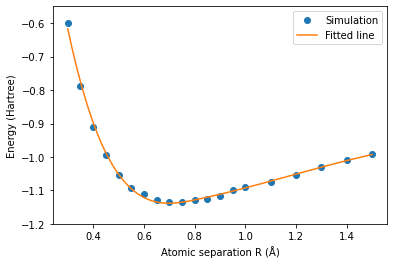

In [169]:
x = Atomic_distance_array
y = min_E_distance

f = UnivariateSpline(x, y, s=0.001)

# calculate new x's and y's
x_new = np.linspace(x[0], x[len(Atomic_distance_array)-1], 1000)
y_new = f(x_new)

plt.plot(x,y,'o', label = 'Simulation')
plt.plot(x_new, y_new, label = 'Fitted line')
#plt.xlim([x[0]-0.15, x[-1] + 0.15 ])
plt.ylim(-1.2,-0.55)
plt.legend()
plt.xlabel('Atomic separation R (Å)')
plt.ylabel('Energy (Hartree)')
plt.show()

In [ ]:
Real Backend ####